In [2]:
%matplotlib notebook
from ABME import *

### Initial model

Grid map with two resources

Agent can harvest resources with an efficiency

	Efficiency, should it be harvest reduction (yield) or percentage harvestable from cell.
	Point 1 leaves no resources on cell, point 2 leaves resources on cell.
    
Agent has metabolism and requires:

    Metabolism_rate * normalized_vector
    Where vector is of length 2 (number of resources) and denotes the percentage of resource      needed.


Resources are ‘grown’ to a capacity determined by us

    Harvested resource are (currently) depleted regardless of efficiency;
    Efficiency is a multiplier for the amount of resources gathered
    e.g.: resource available is 4, efficiency is .25. harvested is 1. Left over is 0


In [74]:
class SugerAgent(Agent):
    # Parameters for agent
    wealth_low = 1; # Random low for all resources seperately
    wealth_high = 3; # random high for all resources (inclusive)
    # Metabolism: The total rate of resouce comsumption
    metabolism_low = 1;
    metabolism_high = 4;
    # max Age in ticks
    age_low = 10;
    age_high = 50;
    #harvest efficiency
    h_eff = 1; # for all
    # Vision
    vis_low = 1;
    vis_high= 6; #Vision in all directions (vonn neumann)
    # Offspring (see def die())
    off_low = 0;
    off_high = 5;
    
    '''
        Describe the agent as a string
    '''
    def __str__(self):
        description = [];
        description.append("Agent %i" % self.id);
        description.append("\tMetabolism (%f-%f): %f" % (self.metabolism_low, self.metabolism_high, self.metabolism));
        for k,v in self.needs.items():
            description.append("\t\tneed %f%% %s" %(v*100.0,k));
        description.append("\tAge (%i-%i): %i (max:%i)" % (self.age_low, self.age_high, self.age, self.max_age));
        description.append("\tVision (%i-%i): %i" % (self.vis_low, self.vis_high, self.vision));
        description.append("\twealth (%f-%f):" %(self.wealth_low, self.wealth_high));
        for name, wealth in self.wealth.items():
            description.append("\t\t%s: %f" % (name,wealth));
        
        fin_str = "";
        for i in description:
            fin_str += i + "\n";
        return fin_str;
    
    '''
        Initialize agent specific variables here
        This function is called when agent is added to model (model.add_agent(...,init_agent=True))
    '''
    def init(self):
        assert(self.model is not None), "Model is None, was agent added to model?";
        assert(self.grid is not None), "Grid is None, Agent was not placed in a grid. This agent requires a grid";
        
        # Initialize wealth
        self.wealth = dict();
        for r_name in self.grid.resources:
            self.wealth[r_name] = np.random.randint(self.wealth_low, self.wealth_high);
            
        # age
        self.age = 0;
        self.max_age = np.random.randint(self.age_low, self.age_high);
        
        # Metabolism
        self.metabolism = np.random.randint(self.metabolism_low, self.metabolism_high);
        self.needs = dict();
        for r_name in self.grid.resources:
            self.needs[r_name] = np.random.random();
        normalize_dict(self.needs); #make vectorlength 1
        
        #harvest efficiency
        self.harvest_eff = dict();
        for r_name in self.grid.resources:
            self.harvest_eff[r_name] = 1.0;
            
        # Vision
        self.vision = np.random.randint(self.vis_low, self.vis_high);

            
    '''
        Define how the agent moves
    '''
    def move(self):
        direction = self.choose_direction();
        self.grid.move_agent(self, move_name=direction, move_to=None, move=None, move_idx=None);
                    
    
    def choose_direction(self):
        '''
            Returns a neighbourhood name ('left', 'right', etc)
            of the chosen direction.
            Requires: self.look()
        '''
        vision = self.look(); #dict[resource][direction]
        
        ### Calculate utility for each direction ###        
        
        #Create a empty vector with a NaN for each direction
        utility_per_direction = np.zeros(len(self.grid.neighbourhood));
        
        # For each resource: Determine the best option
        # and Create a utility based on the best direction and distance per resource
        for resource in vision: #Iterate first level keys = resource names
            
            # Direction selection for a single resource
            (dir_name, distance, max_val) = self.choose_best(vision[resource]);
            
            # Convert direction name to a index (e.g. 'left' -> 0)
            dir_idx = np.where(self.grid.neighbourhood_names == dir_name);
            
            #Determine utility, if something was found
            if not distance == 9999:
                #Note: Dont be negative!
                utility = (max_val)/(0.01 * self.wealth[resource] + distance);
                
                assert(utility >= 0), "Invalid behavior with negative utility"
                #Add utility to best selection accumulator
                utility_per_direction[dir_idx] +=  utility;
        
        # Determine highest utility direction
        direction_index = np.argmax(utility_per_direction);
        
        #Return the name of the direction
        return self.grid.neighbourhood_names[direction_index];
        
    
    def choose_best(self, r_vision):
        '''
            Chooses the best direction for a single resource based on distance and value
            r_vision must be a dict containing directions and their visions.
            e.g.:
                vision = self.look(); #dict[resource][direction]
                (dir_name, distance, max_val) = self.choose_best(vision[resource]);
        '''
        order = copy.copy(self.grid.neighbourhood_names);
        np.random.shuffle(order);
        
        #Initialize best
        #      (dir_name, distance, max_val)
        best = (np.random.choice(order), 9999, 0);
        #Go over all directions by name in order *order* which is random (shuffle)
        for dir_name in order:
            vision = r_vision[dir_name];
            
            #Get highest value and its distance
            max_val = np.max(vision); # highest value
            max_dist = np.argmax(vision); #distance of found maximum
            
            #Check if better than the previous
            if best[2] < max_val and best[1] >= max_dist:
                best = (dir_name, max_dist, max_val);
        
        #Return results
        return best;
        
    
    '''
        Define what the agent does (except for movement)
    '''
    def act(self):
        #harvest
        self.grid.harvest(self, self.harvest_eff);
        #Metabolise
        for n in self.wealth:
            self.wealth[n] -= self.metabolism * self.needs[n];
        #Die?
        if self.age > self.max_age:
            self.die();
            return; #Cant die twice
        for k,r in self.wealth.items():
            if r < 0:
                self.die();
                return; #Cant die twice
            
        # Age
        self.age += 1;
        
        # reproduce
        '''
        accumulated_wealth = sum(self.wealth.values());
        if accumulated_wealth > 10:
            offspring = SugerAgent();
            canidate_places= self.model.grid.get_move_canidates(self);
            if len(canidate_places) > 0:
                self.model.add_agent(offspring, position=random.choice(canidate_places));
                for key in self.wealth:
                    self.wealth[key] -= 5;
         '''   
        
            
    def die(self):
        self.alive = False;
        if self.age > self.max_age:
            reason = "old age";
            n_offspring = np.random.randint(self.off_low, self.off_high);
            for i in range(n_offspring):
                new = SugerAgent();
                self.model.add_agent(new);
                for key,val in self.wealth.items():
                    new.wealth[key] = val/n_offspring;
        else:
            reason = "starvation";
        #print("Agent %i dies at age %i due to %s" %(self.id, self.age, reason));
        #print(self.wealth)
        self.model.remove_agent(self);

Kerbonite up 9999 0
Ebolite down 2 1.0
['down' 'up' 'right' 'left']
[ 0.47619048  0.          0.          0.        ]
down


<IPython.core.display.Javascript object>


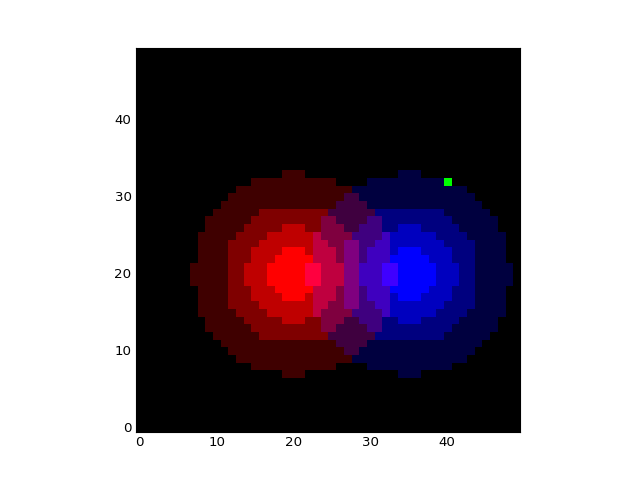

Kerbonite left 9999 0
Ebolite down 1 1.0
['down' 'up' 'right' 'left']
[ 0.90938063  0.          0.          0.        ]
down
Kerbonite up 9999 0
Ebolite down 0 1.0
['down' 'up' 'right' 'left']
[ 10.07058431   0.           0.           0.        ]
down
Kerbonite up 9999 0
Ebolite left 0 1.0
['down' 'up' 'right' 'left']
[ 0.          0.          0.          9.17863547]
left
Kerbonite down 9999 0
Ebolite down 3 2.0
['down' 'up' 'right' 'left']
[ 0.64131378  0.          0.          0.        ]
down
Kerbonite left 9999 0
Ebolite left 0 1.0
['down' 'up' 'right' 'left']
[ 0.          0.          0.          7.79740712]
left
Kerbonite down 9999 0
Ebolite down 2 2.0
['down' 'up' 'right' 'left']
[ 0.93549863  0.          0.          0.        ]
down
Kerbonite left 9999 0
Ebolite left 0 1.0
['down' 'up' 'right' 'left']
[ 0.          0.          0.          6.77750763]
left
Kerbonite up 9999 0
Ebolite right 1 1.0
['down' 'up' 'right' 'left']
[ 0.          0.          0.86415753  0.        ]
right


<IPython.core.display.Javascript object>


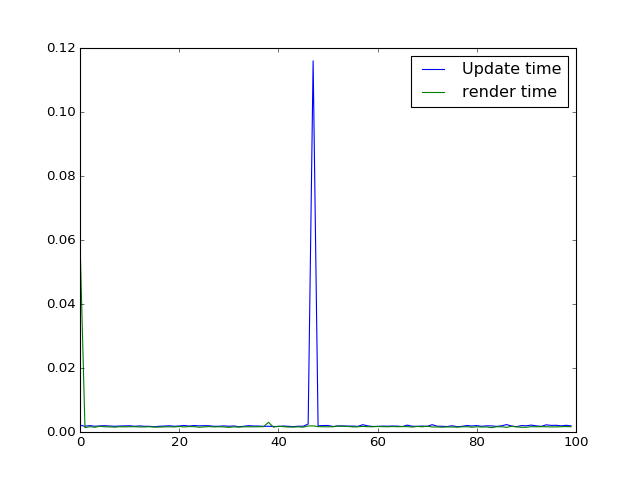

<IPython.core.display.Javascript object>


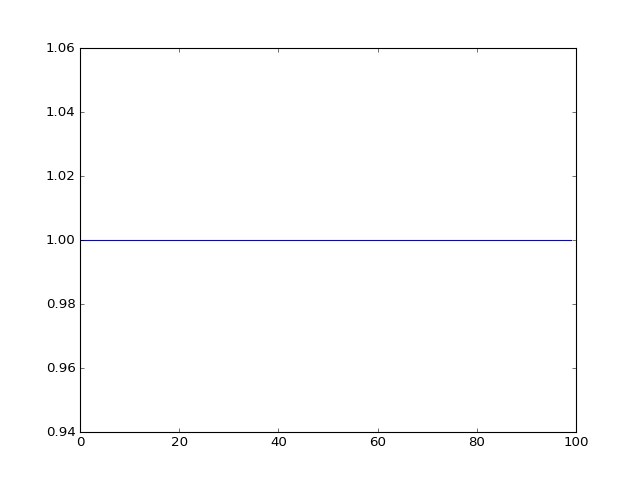

0.30271363258361816 0.00302713632584 0.0113532146853
Agent 1
	Metabolism (1.000000-4.000000): 0.100000
		need 64.955208% Kerbonite
		need 35.044792% Ebolite
	Age (10-50): 100 (max:20000)
	Vision (1-6): 5
	wealth (10.000000-11.000000):
		Kerbonite: 69.504479
		Ebolite: 230.495521



In [75]:
g = Grid(50);
m = Model();
m.set_grid(g);
r1 = Resource("Kerbonite", g);
r2 = Resource("Ebolite", g);
cap=lambda x:np.round(4*np.exp(-(x**2)/(2*40^2)));
reg=lambda x:0.5;
r1.set_capacity(20,20, fun=cap);
r2.set_capacity(35,20, fun=cap);
r1.grow(20,20, fun=cap);
r2.grow(35,20, fun=cap);
#r2.set_capacity(35,35, fun=fun);
#add agents
# for i in range(100):
#     a = SugerAgent();
#     m.add_agent(a);
#     #print(a);
a = SugerAgent();
a.wealth_low = 10;
a.wealth_high = 11;
m.add_agent(a, position=[40,35]);
a.max_age = 20000;
a.metabolism = 0.1;
a.vision = 5;
    
# simulate
times = [];
times_render = [];
population = [];
imgs = [];
imgs2 = [];
#pl.figure(figsize=(10,10))
for i in range(100):
    t = time.time();
    #r1.grow(20,20,fun=reg);
    #r2.grow(35,20, fun=reg);
    m.step_move();
    m.step_act();
    times.append(time.time() - t);
    population.append(len(m.agents));
    
    #Render
    r = r1.resourceMap/np.max(r1.resourceMap);
    g = r2.resourceMap/np.max(r2.resourceMap);
    b = copy.copy(m.grid.agents);
    b[b>0] = 1.0;
    data = np.dstack((r,b,g));
    pl.figure(1);
    img = pl.imshow(np.transpose(data, axes=(1,0,2)), interpolation='nearest', origin='down');
    imgs.append([img]);
    times_render.append(time.time() - t);
    if len(m.agents) == 0:
        break;

fig = pl.figure(1);
ani = animation.ArtistAnimation(fig, imgs, interval=200, blit=True,repeat_delay=0)
HTML(ani.to_html5_video())


#ani.save("ani.mp4")

pl.figure();
pl.plot(times);
pl.plot(np.array(times_render)-times);
pl.legend(['Update time', 'render time'])
pl.figure();
pl.plot(population);
print(sum(times),np.mean(times), np.std(times));

for agent in m.agents:
    print(agent);

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('sim.mp4',writer=writer)

<iframe width="854" height="480" src="https://www.youtube.com/embed/suUpLj3gpeE?list=TLGGNvjjNN0yLZoxNzAxMjAxOA" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>

In [ ]:
print(animation.writers.avail)